In [75]:
#!pip install tslearn

     |████████████████████████████████| 789 kB 23.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [259]:
import boto3
import pandas as pd   
import numpy as np
import statsmodels.api as sm
import math

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from pprint import pprint

sns.set(rc={'figure.figsize':(24,12)})
sns.set_context("talk")

In [152]:
df = pd.read_csv('s3://adfc-bike-census/adfc_data/transformed/combined.csv',parse_dates=['date'])

In [153]:
pivot = df.pivot(index='date', columns=['city', 'station_code'], values='count')
pivot

city                Aschaffenburg Berlin                                    \
station_code                   1      1     2     3     4     5    6    7    
date                                                                         
2016-01-01 00:00:00           NaN    0.0   1.0   NaN   NaN   0.0  NaN  NaN   
2016-01-01 00:15:00           NaN    3.0   1.0   NaN   NaN   2.0  NaN  NaN   
2016-01-01 00:30:00           NaN    1.0   5.0   NaN   NaN   1.0  NaN  NaN   
2016-01-01 00:45:00           NaN    3.0   0.0   NaN   NaN   1.0  NaN  NaN   
2016-01-01 01:00:00           NaN    1.0   6.0   NaN   NaN   0.0  NaN  NaN   
...                           ...    ...   ...   ...   ...   ...  ...  ...   
2021-09-29 22:45:00           3.0   32.0  32.0  12.0  11.0   6.0  5.0  8.0   
2021-09-29 23:00:00           4.0   32.0  34.0  17.0  55.0  13.0  8.0  5.0   
2021-09-29 23:15:00           2.0   32.0  17.0   7.0   9.0  11.0  5.0  4.0   
2021-09-29 23:30:00           1.0   28.0  36.0   8.0  10.0   5.0  2.0  2.0   
2021-09-29 23:45:00           1.0   13.0  21.0   7.0  10.0   0.0  8.0  5.0   

city                            ... Stuttgart                                \
station_code           8    9   ...        6    7    8    9    10   11   12   
date                            ...                                           
2016-01-01 00:00:00   0.0  1.0  ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2016-01-01 00:15:00   0.0  2.0  ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2016-01-01 00:30:00   0.0  1.0  ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2016-01-01 00:45:00   3.0  0.0  ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2016-01-01 01:00:00   2.0  1.0  ...       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                   ...  ...  ...       ...  ...  ...  ...  ...  ...  ...   
2021-09-29 22:45:00  11.0  5.0  ...       1.0  1.0  3.0  0.0  0.0  0.0  0.0   
2021-09-29 23:00:00  13.0  5.0  ...       0.0  1.0  1.0  1.0  0.0  1.0  0.0   
2021-09-29 23:15:00   9.0  3.0  ...       0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2021-09-29 23:30:00   6.0  4.0  ...       0.0  1.0  0.0  2.0  0.0  0.0  0.0   
2021-09-29 23:45:00   3.0  1.0  ...       0.0  1.0  2.0  2.0  1.0  0.0  0.0   

city                                 
station_code          13    14   15  
date                                 
2016-01-01 00:00:00  NaN   NaN  NaN  
2016-01-01 00:15:00  NaN   NaN  NaN  
2016-01-01 00:30:00  NaN   NaN  NaN  
2016-01-01 00:45:00  NaN   NaN  NaN  
2016-01-01 01:00:00  NaN   NaN  NaN  
...                  ...   ...  ...  
2021-09-29 22:45:00  0.0   9.0  7.0  
2021-09-29 23:00:00  0.0   2.0  6.0  
2021-09-29 23:15:00  1.0  15.0  6.0  
2021-09-29 23:30:00  0.0  11.0  1.0  
2021-09-29 23:45:00  0.0   3.0  4.0  

[201480 rows x 74 columns]

In [154]:
daily=pivot.resample('D').sum()

In [155]:
stations = daily.columns.values.tolist()

In [156]:
daily.isna().sum().describe()

count    74.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
dtype: float64

In [262]:
pd.options.mode.chained_assignment = None  # default='warn'

def get_normalized(station, df=daily, plot=False):
    
    city = station[0]
    num = station[1]
    
    station = pd.DataFrame(daily[city][num])
    station.columns = ['count']
  
    
    station['mov_avg_week'] = station['count'].rolling(7).mean()
    station['year'] = station['count'].rolling(365).mean()
    station['normal'] = MinMaxScaler().fit_transform((station.mov_avg_week / station.year).values.reshape(-1,1))
    
    
    res = sm.tsa.seasonal_decompose(station.fillna(0).normal.values,
                                period=365,
                                model="additive")
    station['residual'] = res.resid
    station['trend'] = res.trend
    station['seasonal'] = res.seasonal
    
    if plot:
        sns.lineplot(x='date', y='count', data=station)
        plt.show()
    
        ax  = sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(station, ignore_index=False, value_vars=['mov_avg_week', 'year']))
        ax.set_title(city +str(num))

        # Define the date format
        date_form = DateFormatter("%Y-%m")
        ax.xaxis.set_major_formatter(date_form)

        # Ensure a major tick for each week using (interval=1) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45);
        plt.show()
    
        ax = sns.lineplot(x='date', y='normal', data=station)
        ax.set_title(city +str(num)  + ' normalized')
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45);
        plt.show()
        
        ax = sns.lineplot(x='date', y='trend', data=station)
        ax.set_title(city +str(num)  + ' trend')
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45);
        plt.show()
        
        ax = sns.lineplot(x='date', y='seasonal', data=station)
        ax.set_title(city +str(num)  + ' seasonal')
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45);
        plt.show()
        
        ax = sns.lineplot(x='date', y='residual', data=station)
        ax.set_title(city +str(num)  + ' residual')
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.xticks(rotation=45);
        plt.show()
        
        
    return station.fillna(0)


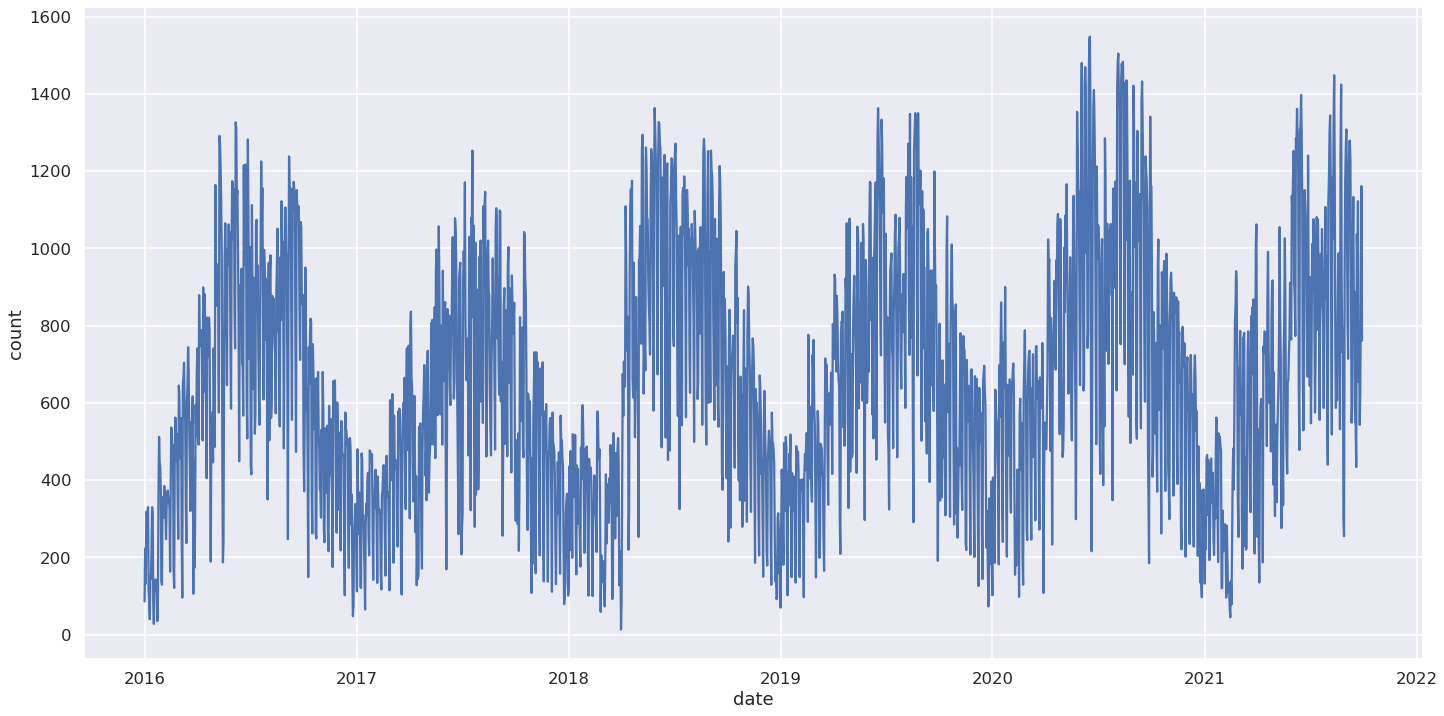

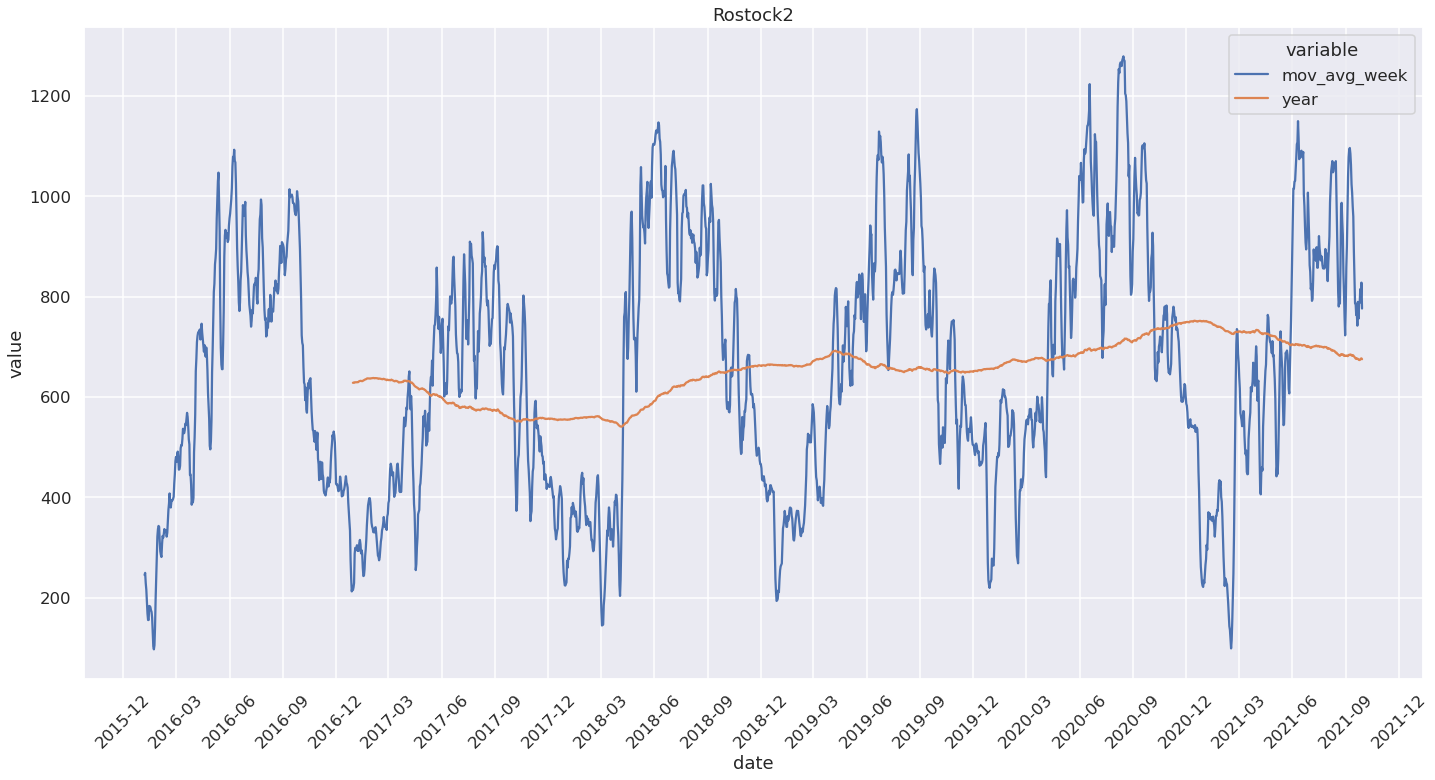

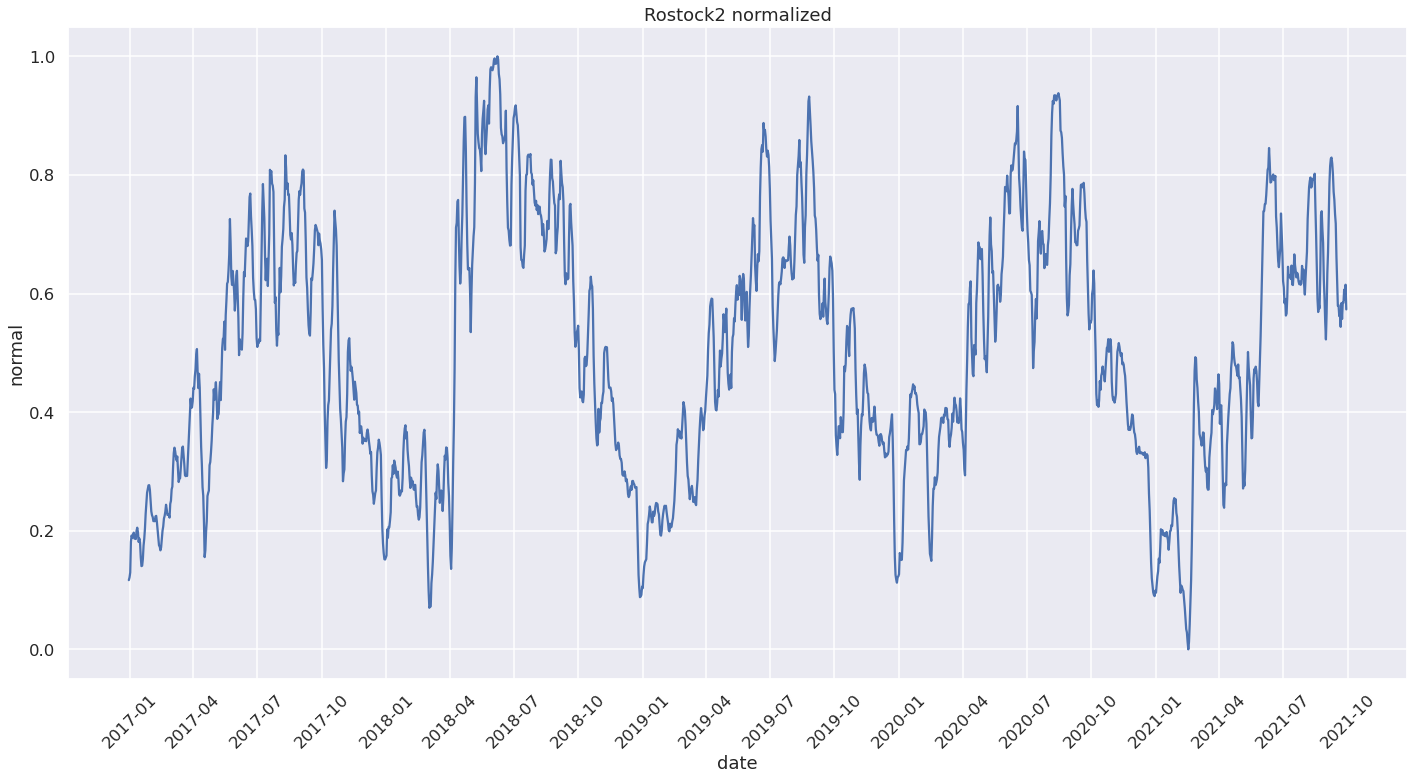

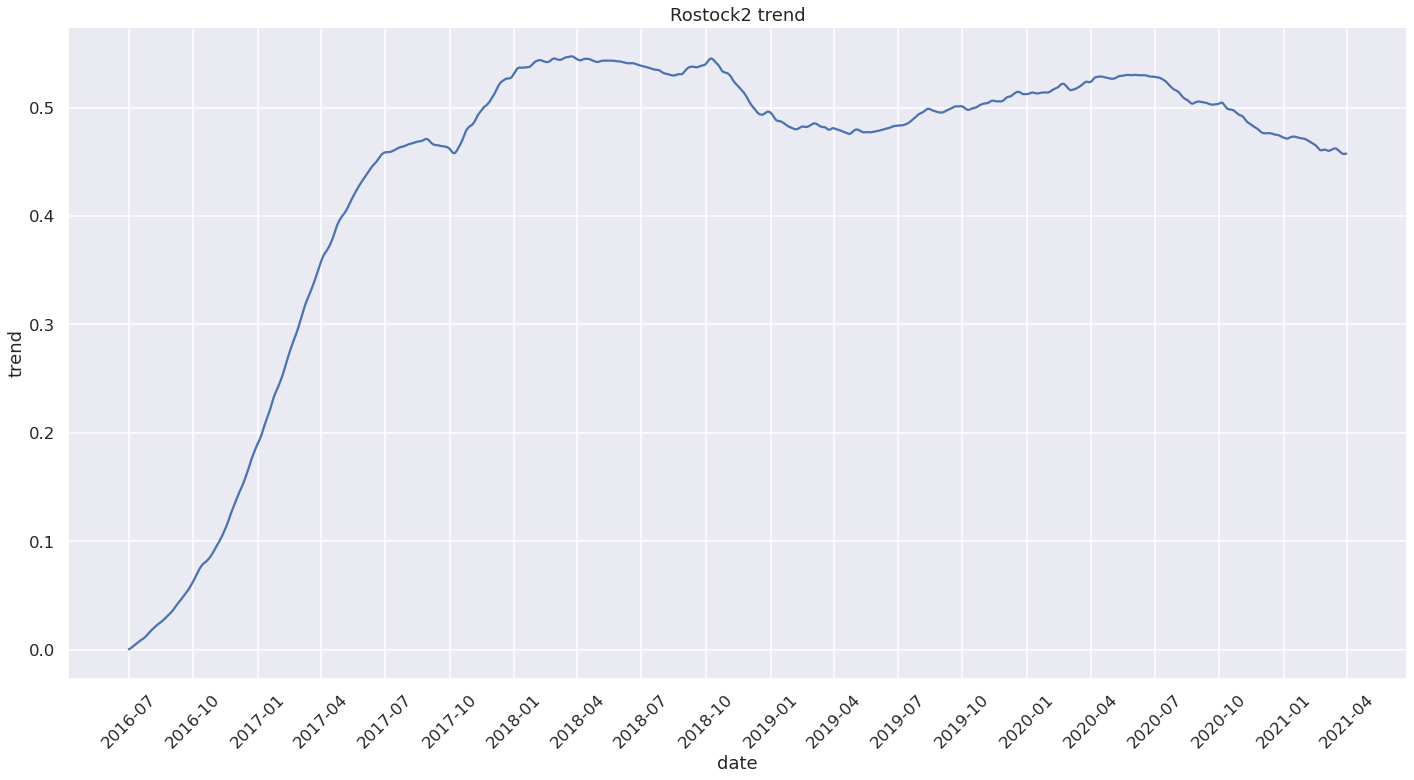

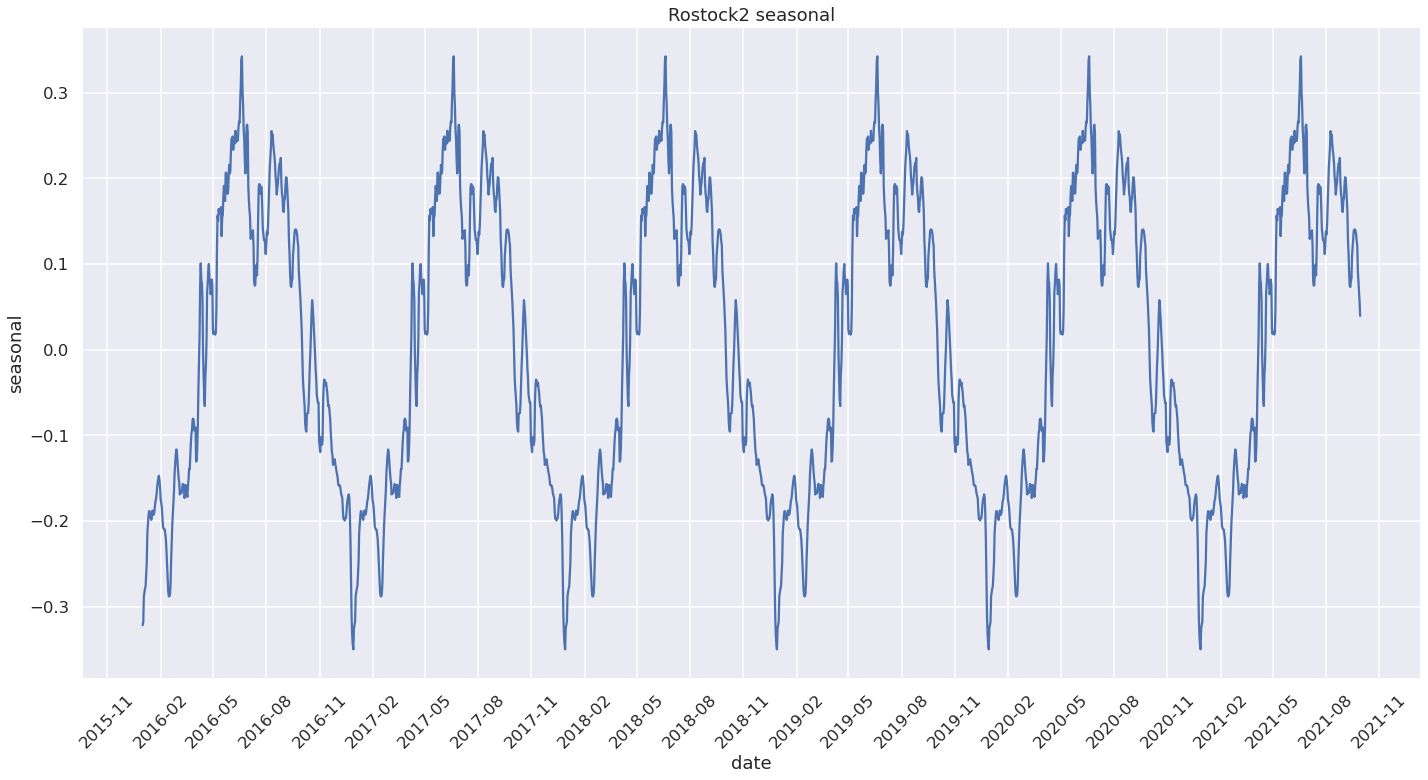

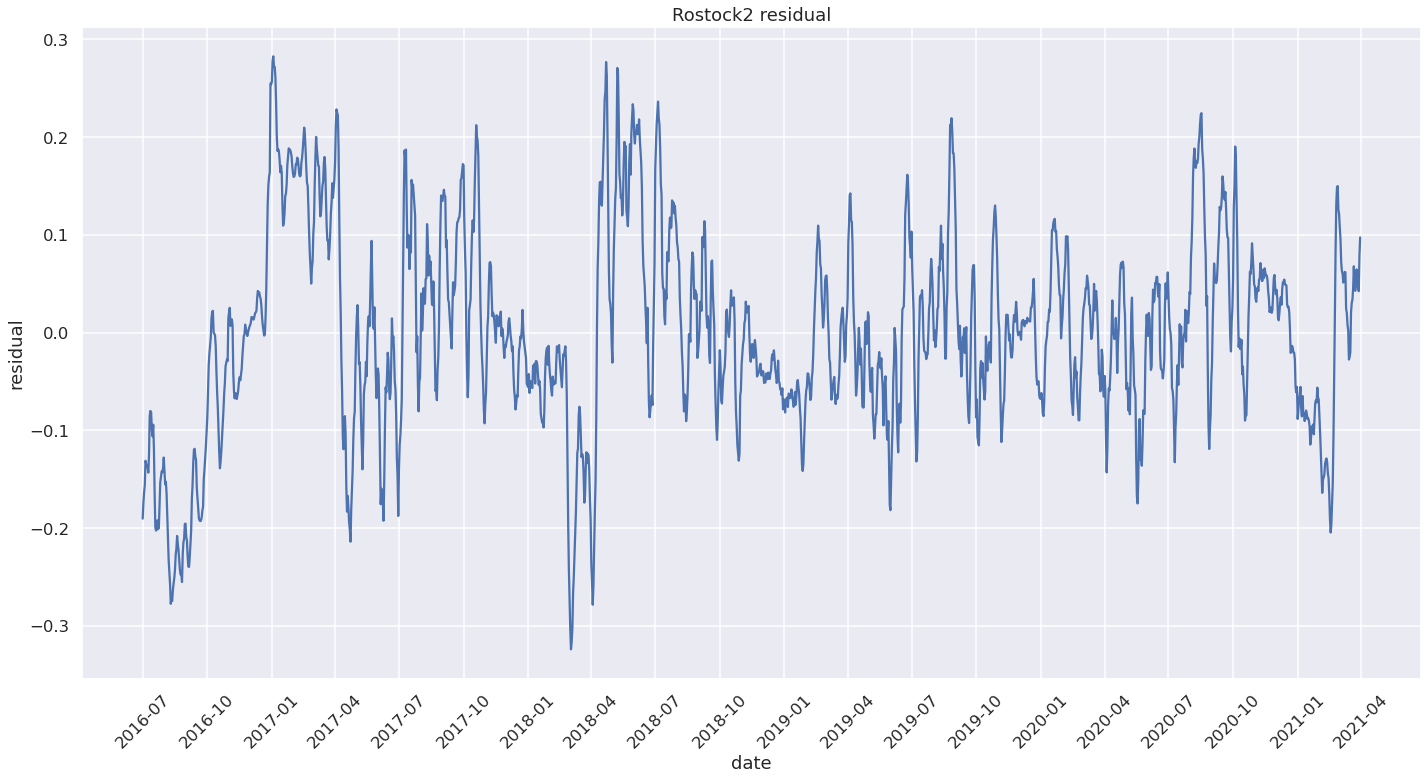

In [263]:
x=get_normalized(('Rostock',2),daily,True)

In [265]:
normalized_dfs={}
for s in stations:
    #print(s)
    normalized_dfs[s[0]+str(s[1])]=get_normalized(s)

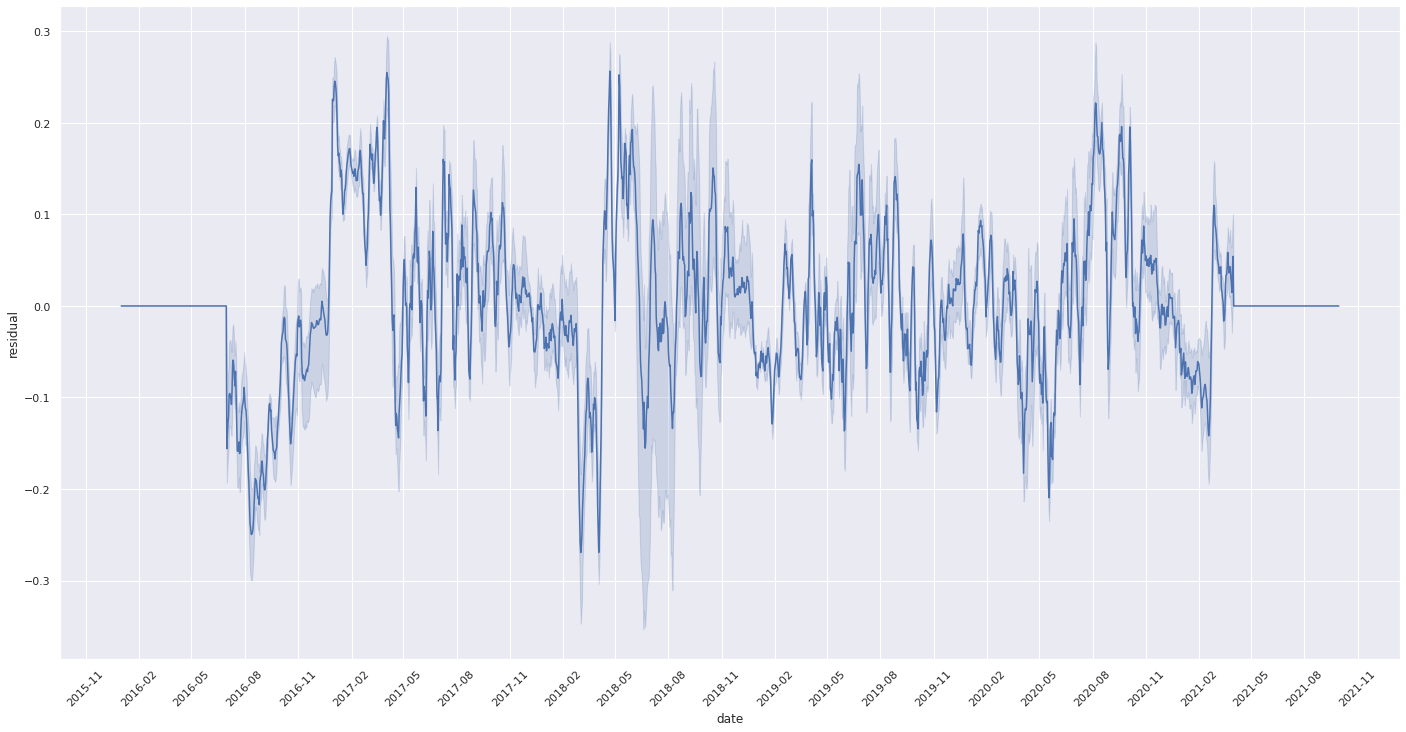

In [126]:
ax  = sns.lineplot(x='date', y='residual',
                   data=pd.DataFrame(pd.concat([normalized_dfs['Rostock1'],
                                                normalized_dfs['Rostock2'],
                                               normalized_dfs['Rostock3'],
                                               normalized_dfs['Rostock4'],
                                               normalized_dfs['Rostock5'],
                                               ])))

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45);
plt.show()

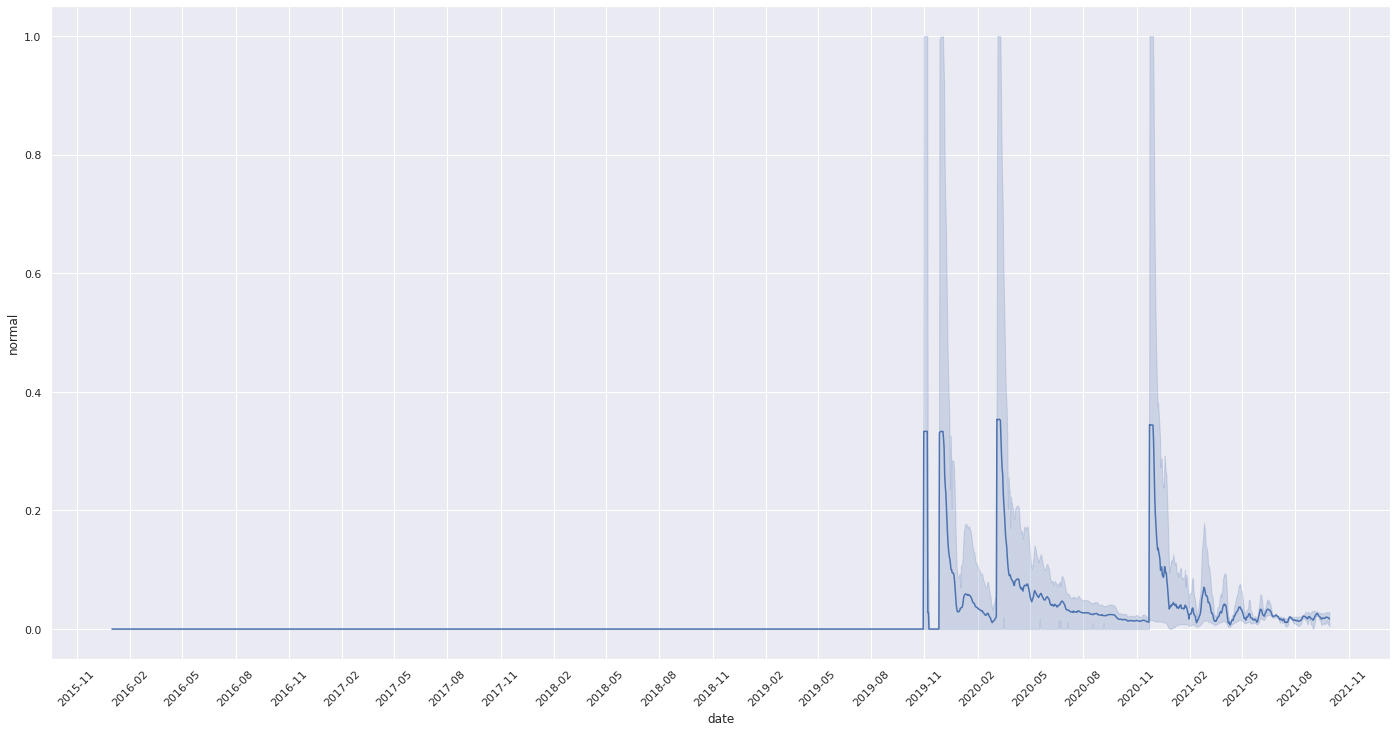

In [238]:
ax  = sns.lineplot(x='date', y='normal',
                   data=pd.DataFrame(pd.concat([normalized_dfs['Köln12'],
                                                normalized_dfs['Köln13'],
                                               normalized_dfs['Köln14']
                                               ])))

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45);
plt.show()

# Clustering
inspired by [this notebook](https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering#2.-Analysis)

In [275]:
series = [df.trend.resample('W').mean() for df in normalized_dfs.values()]
orig_series = [df.mov_avg_week for df in normalized_dfs.values()]

In [267]:
cluster_count = math.ceil(math.sqrt(len(normalized_dfs))) 

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(series)

In [278]:
labelled_series = list(zip(orig_series,labels))
clusters = {}
for l in  set(labels): 
    clusters[l] = [s for (s,label) in labelled_series if l==label]

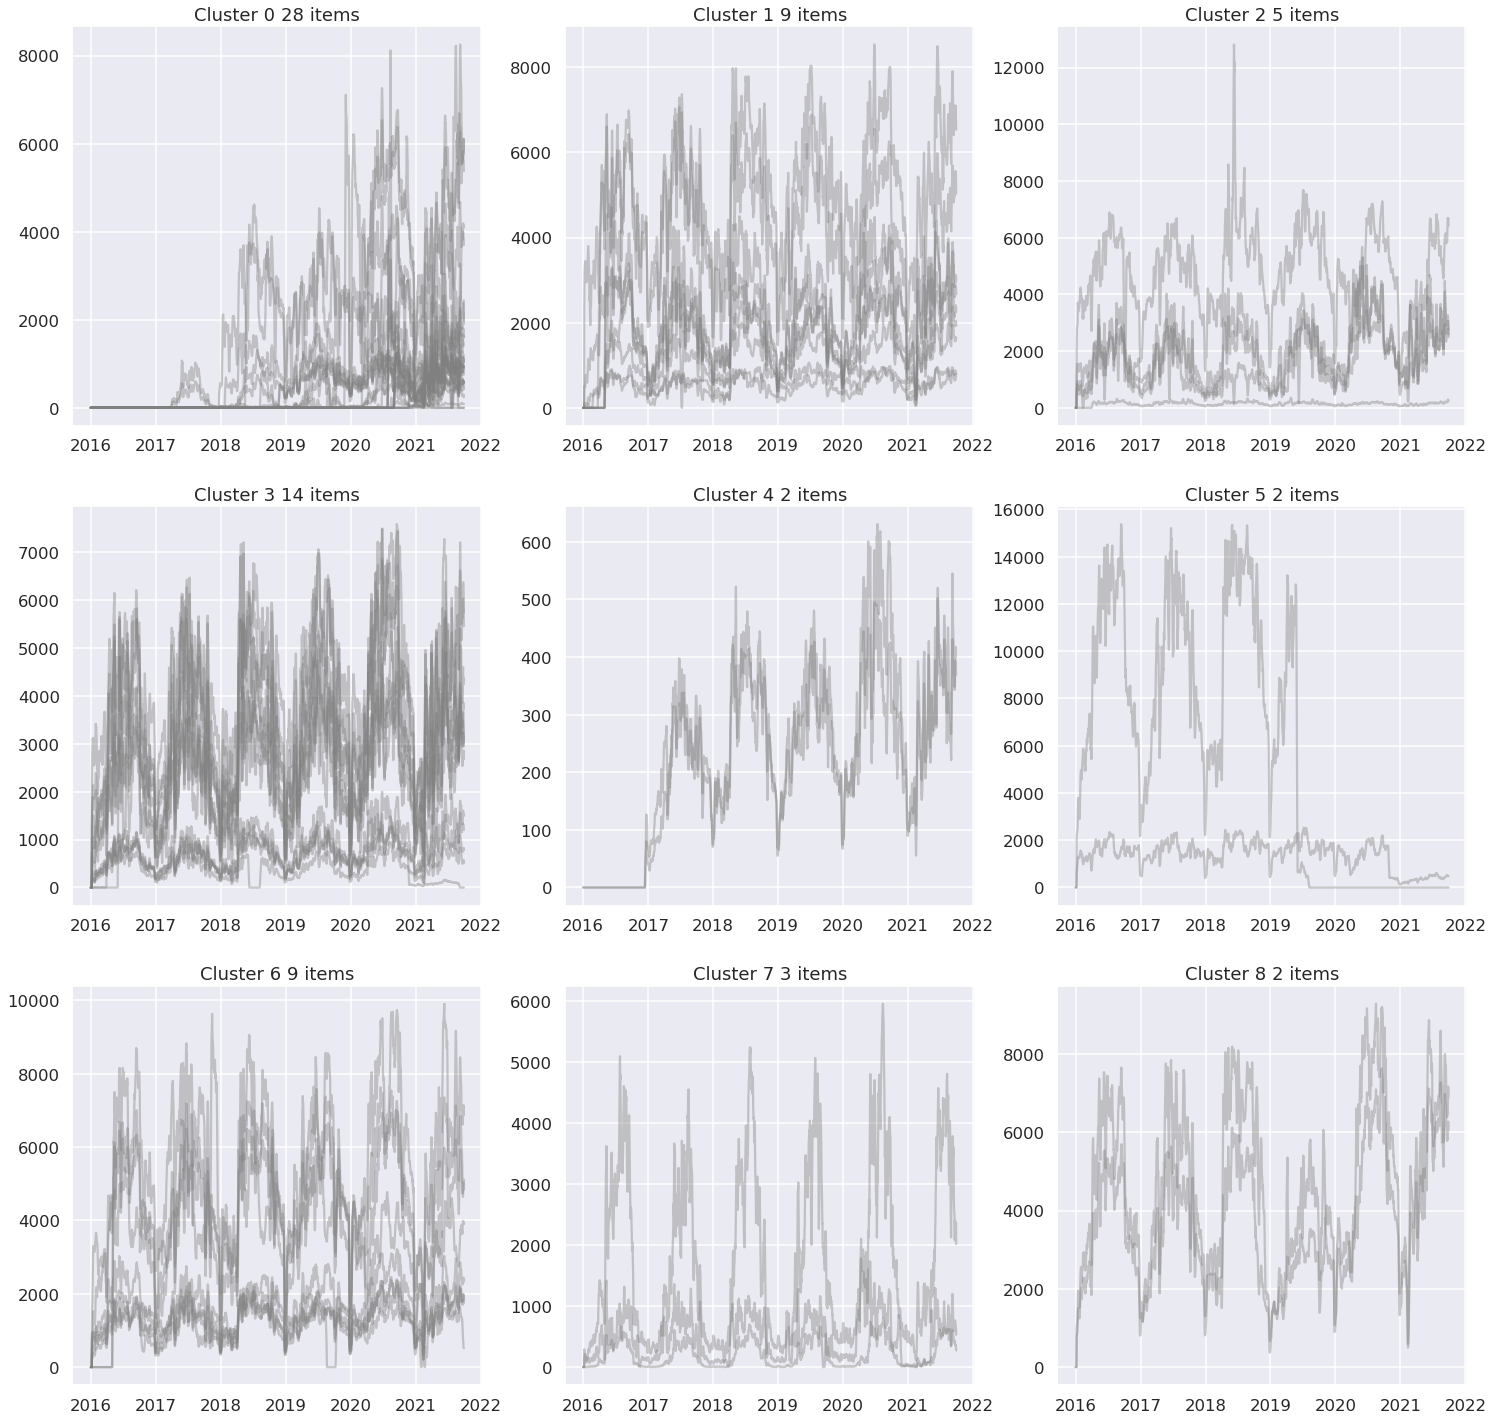

In [279]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
#fig.suptitle('Clusters')
row_i = 0
column_j = 0
for (num, cluster) in clusters.items():
    for series in cluster:
        axs[row_i, column_j].plot(series,c='gray',alpha=0.4)

    axs[row_i, column_j].set_title(f'Cluster {num} {len(cluster)} items')
    column_j += 1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()



In [280]:
labelled_names = list(zip(normalized_dfs.keys(),labels))

cluster_names ={}
for l in  set(labels): 
    cluster_names[l] = [name for (name,label) in labelled_names if l==label]

In [281]:
pprint(cluster_names)

{0: ['Aschaffenburg1',
     'Berlin18',
     'Bochum1',
     'Bochum2',
     'Darmstadt1',
     'Dortmund1',
     'Köln11',
     'Köln12',
     'Köln13',
     'Köln14',
     'Köln15',
     'Ludwigsburg1',
     'Osnabrück1',
     'Rostock8',
     'Rostock9',
     'Rostock11',
     'Rostock12',
     'Stuttgart5',
     'Stuttgart6',
     'Stuttgart7',
     'Stuttgart8',
     'Stuttgart9',
     'Stuttgart10',
     'Stuttgart11',
     'Stuttgart12',
     'Stuttgart13',
     'Stuttgart14',
     'Stuttgart15'],
 1: ['Berlin5',
     'Berlin6',
     'Berlin7',
     'Berlin11',
     'Berlin13',
     'Berlin17',
     'Köln7',
     'Köln9',
     'Rostock3'],
 2: ['Düsseldorf1', 'Karlsruhe1', 'Köln4', 'Köln5', 'Köln8'],
 3: ['Berlin3',
     'Berlin12',
     'Bonn1',
     'Köln1',
     'Köln2',
     'Köln3',
     'Köln6',
     'Köln10',
     'Rostock1',
     'Rostock2',
     'Rostock4',
     'Rostock5',
     'Stuttgart1',
     'Stuttgart2'],
 4: ['Stuttgart3', 'Stuttgart4'],
 5: ['Berlin16', 'Heidel

In [ ]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue']

In [234]:
{name: colors[cluster] for name,cluster in labelled_names}

{'Aschaffenburg1': 'purple',
 'Berlin1': 'blue',
 'Berlin2': 'blue',
 'Berlin3': 'blue',
 'Berlin4': 'blue',
 'Berlin5': 'blue',
 'Berlin6': 'blue',
 'Berlin7': 'blue',
 'Berlin8': 'blue',
 'Berlin9': 'blue',
 'Berlin10': 'blue',
 'Berlin11': 'blue',
 'Berlin12': 'blue',
 'Berlin13': 'blue',
 'Berlin14': 'blue',
 'Berlin15': 'blue',
 'Berlin16': 'orange',
 'Berlin17': 'blue',
 'Berlin18': 'lightred',
 'Bochum1': 'purple',
 'Bochum2': 'purple',
 'Bonn1': 'darkblue',
 'Darmstadt1': 'red',
 'Dortmund1': 'purple',
 'Düsseldorf1': 'blue',
 'Düsseldorf2': 'beige',
 'Düsseldorf3': 'green',
 'Heidelberg1': 'orange',
 'Heidelberg2': 'orange',
 'Karlsruhe1': 'blue',
 'Köln1': 'green',
 'Köln2': 'darkblue',
 'Köln3': 'green',
 'Köln4': 'green',
 'Köln5': 'green',
 'Köln6': 'darkblue',
 'Köln7': 'darkblue',
 'Köln8': 'green',
 'Köln9': 'darkblue',
 'Köln10': 'darkblue',
 'Köln11': 'purple',
 'Köln12': 'red',
 'Köln13': 'red',
 'Köln14': 'red',
 'Köln15': 'red',
 'Ludwigsburg1': 'purple',
 'Osnabrü

<AxesSubplot:xlabel='date'>

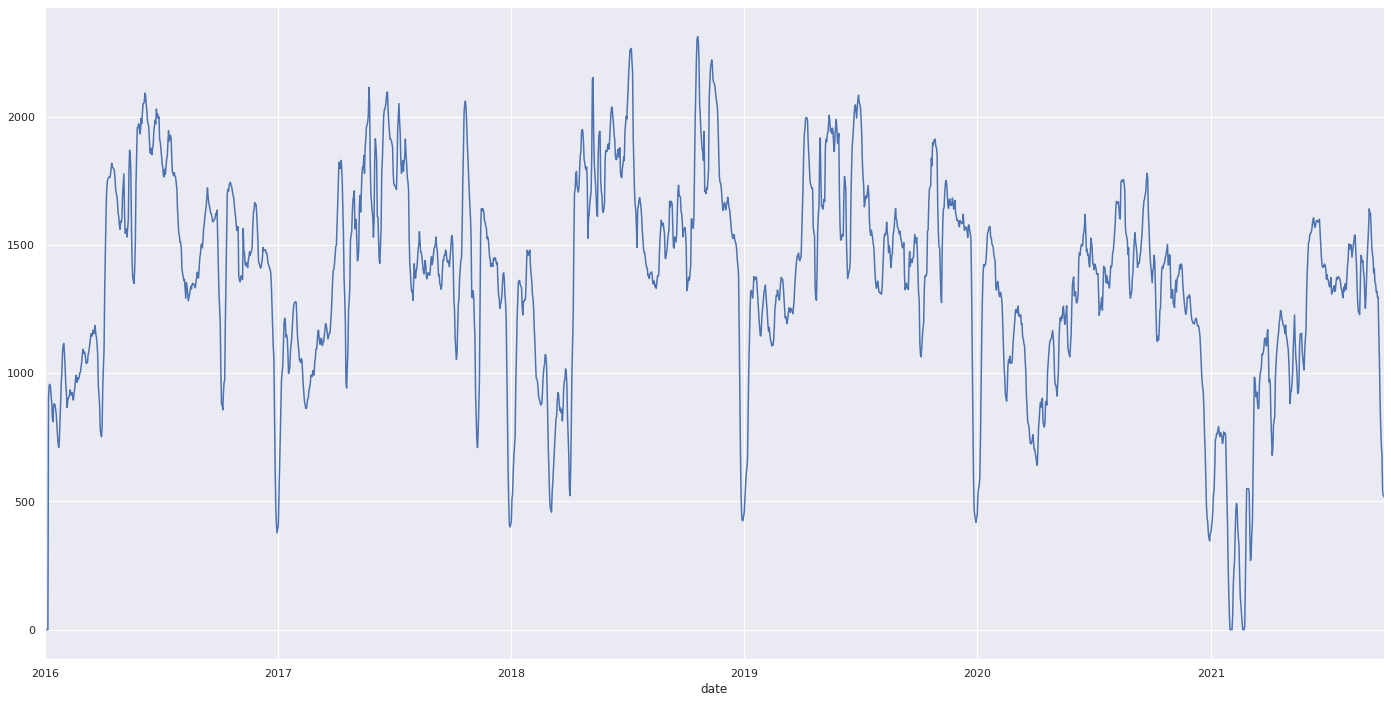

In [252]:
normalized_dfs['Rostock7'].mov_avg_week.plot()

<AxesSubplot:xlabel='date'>

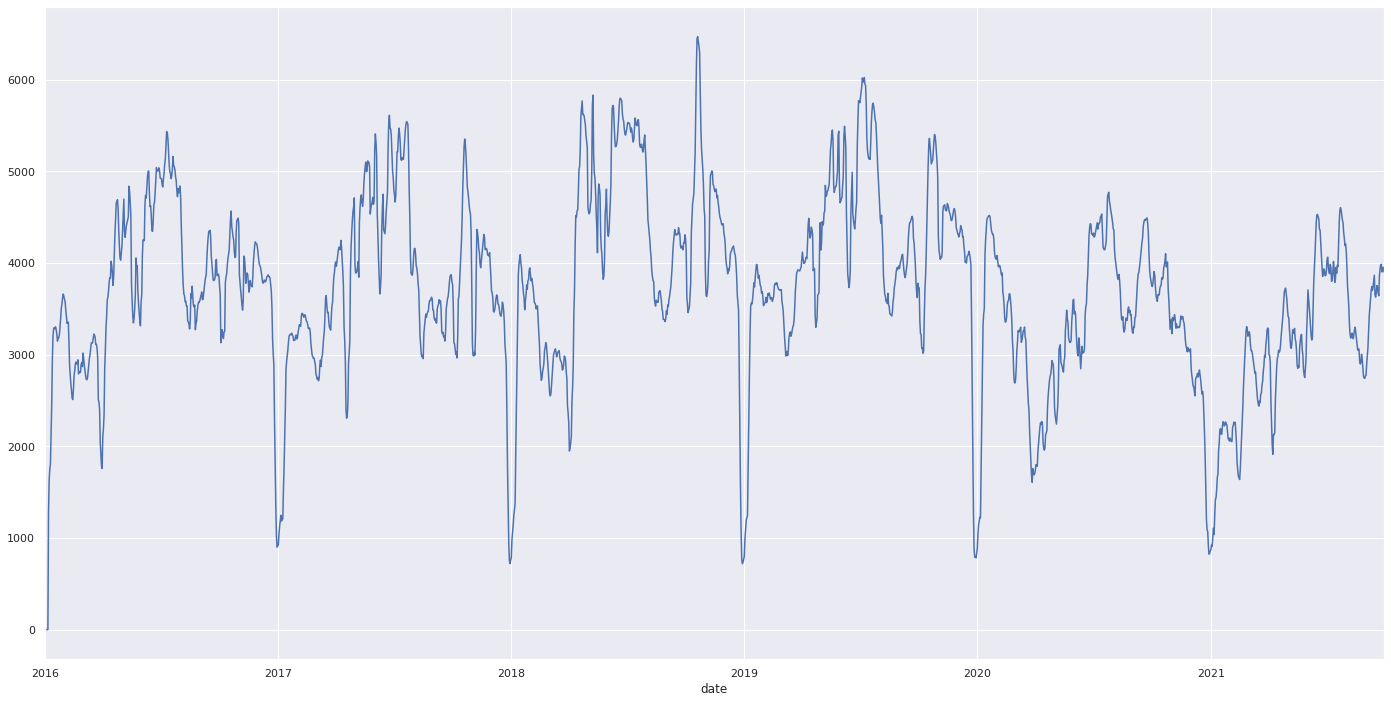

In [254]:
normalized_dfs['Heidelberg1'].mov_avg_week.plot()